# Wikipedia Network Research - PastNet Hackathon
### _Patrick Gildersleve_ - _@pgildersleve_ - _GH:pgilders_ - _patrick.gildersleve [at] oii.ox.ac.uk_

The following is a brief tutorial on how to generate and use Wikipedia network data.

Useful auxiliary datasets include:
- Dumps of lots of different Wikipedia data: https://dumps.wikimedia.org/other/analytics/
- API documentation: https://www.mediawiki.org/wiki/API:Properties
- Python package for Wikipedia page views: https://github.com/mediawiki-utilities/python-mwviews
- Networkx documentation https://networkx.github.io/documentation/networkx-2.3/

Contents:
1. [Sample Functions](#functions)
2. [Generating Networks](#generatingnetworks)
    1. [Wikilinks](#wikilinks)
    2. [Content-based](#content)
    3. [Clickstream](#clickstream)
3. [Studying a Network](#studying)
4. [Appendix: Running a Query](#query)


## Sample Functions <a name="functions"></a>
Helper Functions (click to expand):

In [5]:
import pandas as pd
import networkx as nx
import requests
import matplotlib.pyplot as plt

langlist = ['en', 'fr', 'de'] # edit as appropriate
csvpath = '~/Downloads/' # edit as appropriate
clickstream_dfs = {l:pd.read_csv(csvpath+'clickstream-%swiki-2019-03.tsv' %l,
                                   sep = '\t', index_col=None, header=None, names=['prev', 'curr', 'type', 'n']) for l in langlist}
for k, v in clickstream_dfs.items():
    clickstream_dfs[k] = v[v['type']=='link'][['prev', 'curr', 'n']]
    
def query(request, lang):
    '''
    Make queries to the wikipedia API
    '''
    request['action'] = 'query'
    request['format'] = 'json'
    request['redirects'] = ''
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://%s.wikipedia.org/w/api.php' %lang, params=req).json()
        if 'error' in result:
            print(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'query' in result:
            yield result['query']
        if 'continue' not in result:
            break
        lastContinue = result['continue']


def parse(request, lang):
    '''
    Parse wikipedia pages (or their past revisions)
    '''
    request['action'] = 'parse'
    request['format'] = 'json'
    request['redirects'] = ''
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://%s.wikipedia.org/w/api.php' %lang, params=req).json()
        if 'error' in result:
            print(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'parse' in result:
            yield result['parse']
        if 'continue' not in result:
            break
        lastContinue = result['continue']

        
def chunks(l, n):
    '''
    API frequently limits number of pages allowed in one call, this breaks up lists of pages into smaller chunks
    '''
# For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
        


def revid_from_date(article, language, date=False):
    '''
    Get the revision ID of an article at a particular point in time
    '''
    params = {'titles':article, 'prop':'revisions', 'rvstart':date, 'rvprop':'ids|timestamp', 'rvlimit':1}
    if not date:
        params['rvdir'] = 'older'
        del params['rvstart']
    try:
        return list(next(query(params, language))['pages'].values())[0]['revisions'][0]['revid']
    except KeyError:
        return None
    



Network generators (click to expand):

In [41]:
def wikilink_network(articles, language, fix_outer_redirects = False):
    '''
    Create a network of Wikipedia articles.
    1. Take a list of core articles, get all of the out-links from and in-links to these articles.
    2. Get all the links between articles in the larger set of pages.
    (Optional 3. Resolve redirects on the 1.5 hop links, this is time consuming)
    
    This function can take a long time for articles with many links, or articles that are very popular across Wikipedia e.g. 'United States'
    '''

    print('Getting outlinks')
    page_chunks = ['|'.join(x) for x in chunks(articles, 50)]
    outlinks = []
    for pages in page_chunks:
        out_params = {'titles':pages, 'prop':'links', 'pllimit':'max', 'plnamespace':'0'}
        outlinks.extend([(v['title'], x['title']) for p in query(out_params, language) for v in p['pages'].values() for x in v.get('links', [])])

    print('Getting inlinks')        
    inlinks = []
    for page in articles:
        in_params = {'list':'backlinks', 'bltitle':page, 'blnamespace':'0', 'bllimit':'max', 'blfilterredir':'nonredirects', 'blredirect':'True'} # redirects x 2
        for i in query(in_params, 'en'):            
            inlinks.extend([(x['title'], page) for x in i['backlinks'] if 'redirect' not in x.keys()])
            inlinks.extend([(y['title'], page) for x in i['backlinks'] for y in x.get('redirlinks', [])])

    redirects = {}
    all_articles = list((set([x[1] for x in outlinks])|set([x[0] for x in inlinks])) - set(articles))
    print('Getting links between %d pages' %len(all_articles))
    page_chunks = ['|'.join(x) for x in chunks(all_articles, 50)]
    links = []
    for n, pages in enumerate(page_chunks):
        print('%.2f%%' %(100*n/len(page_chunks)))
        out_params = {'titles':pages, 'prop':'links', 'pllimit':'max', 'plnamespace':'0'}
        for p in query(out_params, language):
            if 'redirects' in p.keys():
                redirects.update({x['from']:x['to'] for x in p['redirects']})
            links.extend([(v['title'], x['title']) for v in p['pages'].values() for x in v.get('links', [])])
    
    if fix_outer_redirects:
        print('Fixing outer redirects over %d pages' %len(set([i[1] for i in links])))
        page_chunks = ['|'.join(x) for x in chunks(list(set([i[1] for i in links])), 50)]
        for n, pages in enumerate(page_chunks):
            if n%50==0: print('%.2f%%' %(100*n/len(page_chunks)))
            rd_params = {'titles':pages}
            redirects.update({x['from']:x['to'] for x in next(query(rd_params, language)).get('redirects', [])})

    all_articles = [redirects.get(x, x) for x in all_articles]
    outlinks = [(x[0], redirects.get(x[1], x[1])) for x in outlinks]
    links = [(x[0], redirects.get(x[1], x[1])) for x in links if redirects.get(x[1], x[1]) in all_articles+articles]
    
    edgelist = list(set(outlinks + inlinks + links))
        
    return nx.DiGraph(edgelist)
  
       
def content_network(articles, language, sectionids=None, date = None):
    '''
    Create a network of Wikipedia articles based on links in page content
    This can be the whole page (akin to wikilink_network), but is better suited to picking links from an particular sections,
    such as the introduction.
    Section ids is a list of the sections requested, sections start at id=0.
    
    This function can also generate networks from a particular point in time.
    
    Note that we only generate the network from outlinks, not inlinks.
    '''

    print('getting core links')
    links = []
    redirects = {}
    for i in articles:
        if date:
            revid = revid_from_date(i, language, date)
            if revid:
                params = {'oldid':revid, 'prop':'links'}
            else:
                continue
        else:
            params = {'page':i, 'prop':'links'}
        if sectionids:
            for sectionid in sectionids:
                params['section'] = sectionid
                for p in parse(params, language):
                    links.extend([(p['title'], x['*']) for x in p['links'] if x['ns']==0])
        else:
            for p in parse(params, language):
                links.extend([(p['title'], x['*']) for x in p['links'] if x['ns']==0])
    
    redirects = {}
    newpages = set([x[1] for x in links])-set(articles)     
    print('getting links from %d articles' %len(newpages))
    for n, i in enumerate(newpages):
        if n%20==0: print('%.2f%%' %(100*n/len(newpages)))
        if date:
            revid = revid_from_date(i, language, date)
            if revid:
                params = {'oldid':revid, 'prop':'links'}
            else:
                continue
        else:
            params = {'page':i, 'prop':'links'}
        if sectionids:
            for sectionid in sectionids:
                params['section'] = sectionid 
                for p in parse(params, language):
                    redirects[i] = p['title']
                    links.extend([(p['title'], x['*']) for x in p['links'] if x['ns']==0])
        else:
            for p in parse(params, language):
                redirects[i] = p['title']
                links.extend([(p['title'], x['*']) for x in p['links'] if x['ns']==0])
   
    newpages = [redirects.get(x, x) for x in newpages]
    links = [(x[0], redirects.get(x[1], x[1])) for x in links]
    edgelist = pd.DataFrame(list(set([x for x in links if x[1] in list(newpages)+articles])))
    edgelist.columns = ['source', 'target']
    
    return nx.from_pandas_edgelist(edgelist)



def clickstream_network(articles, clickstream_df, language, cutoff = 0, depth = 1, get_redirects = True):
    '''
    Generate weighted network based on clickstream data (with an optional cutoff for number of link transitions).
    1. Take a list of core articles, get all of the out-links from and in-links to these articles.
    2. Get all the links between articles in the larger set of pages.
    3. Repeat up to a specified depth
    
    Much quicker than wikilink_network, content_network.
    '''

    articles_u = [x.replace(' ', '_') for x in articles]
    dfl = clickstream_df.copy()
    if cutoff > 0 :
        dfl = dfl[dfl['n']>cutoff]
        
    all_articles = []
    for i in range(depth):
        in_n = dfl[dfl['curr'].isin(articles_u) == True]['prev']
        out_n = dfl[dfl['prev'].isin(articles_u) == True]['curr']
        all_articles = list(set(articles_u) | set(in_n) | set(out_n))        
        articles_u = all_articles
            
    print('getting links')
    edgelist = dfl[(dfl['curr'].isin(all_articles) == True)&(dfl['prev'].isin(all_articles) == True)][['prev', 'curr', 'n']]
    edgelist.columns = ['source', 'target', 'weight']
    edgelist['source'] = edgelist['source'].str.replace('_', ' ')
    edgelist['target'] = edgelist['target'].str.replace('_', ' ')
    
    print('getting redirects')
    redirects = {}
    all_articles = set(edgelist['source'])|set(edgelist['target'])
    page_chunks = ['|'.join(x) for x in chunks(list(all_articles), 50)]
    for n, pages in enumerate(page_chunks):
        if n%50==0: print('%.2f%%' %(100*n/len(page_chunks)))
        rd_params = {'titles':pages}
        redirects.update({x['from']:x['to'] for x in next(query(rd_params, language)).get('redirects', [])})
    
    edgelist['source'] = edgelist['source'].apply(lambda x: redirects.get(x,x))
    edgelist['target'] = edgelist['target'].apply(lambda x: redirects.get(x,x))
    
    return nx.from_pandas_edgelist(edgelist, edge_attr='weight')


def multi_lang_networks(articles, orig_language, languages, network_type, **kwargs):
    '''
    Take list of articles in one language, generate Wiki network in several language.
    1. Gets interlanguage links of supplied list of articles
    2. Generate network in each language according to specified method, return as dictionary
    3. Supplies dictionary of translations for each new network
    '''
    lang_dict = {l:{} for l in languages}
    network_dict = {}
    translations = {l:{} for l in languages}
    page_chunks = ['|'.join(x) for x in chunks(articles, 50)]
    
    print(orig_language)
    kwargs2 = kwargs.copy()
    kwargs2['language'] = orig_language        
    if network_type == clickstream_network:
        kwargs2['clickstream_df'] = kwargs['clickstream_dfs'][orig_language]
        del kwargs2['clickstream_dfs']
    network_dict[orig_language] = network_type(articles, **kwargs2)
    translations[orig_language] = {x:x for x in network_dict[orig_language].nodes()}
    
    for l in languages:
        print(l)
        for i in page_chunks:
            params = {'titles':i, 'prop':'langlinks', 'lllang':l}
            lang_dict[l].update({y['title']:y['langlinks'][0]['*']  for x in query(params, orig_language)
                for y in x['pages'].values() if 'langlinks' in y.keys()})
        if set(articles)-set(lang_dict[l].keys()):
            print('Some articles not included in %s network' %l, set(articles)-set(lang_dict[l].keys()))
            
        kwargs2 = kwargs.copy()
        kwargs2['language'] = l        
        if network_type == clickstream_network:
            kwargs2['clickstream_df'] = kwargs['clickstream_dfs'][l]
            del kwargs2['clickstream_dfs']
            
        network_dict[l] = network_type(list(lang_dict[l].values()), **kwargs2)
        
        print('getting translations')
        trans_chunks = ['|'.join(x) for x in chunks(list(network_dict[l].nodes()), 50)]
        for i in trans_chunks:
            params = {'titles':i, 'prop':'langlinks', 'lllang':orig_language}
            translations[l].update({y['title']:y['langlinks'][0]['*']  for x in query(params, l)
                    for y in x['pages'].values() if 'langlinks' in y.keys()})
       
    return network_dict, translations

Network attribute functions (click to expand):

In [43]:
def get_network_properties(network, wikiquery, language, fix_redirects = True):
    '''
    A general function to attach properties from wiki queries to nodes in a network.
    Doesn't handle all properties appropriately, some data cleaning likely required afterwards.
    '''
    
    page_chunks = ['|'.join(x) for x in chunks(list(network.nodes()), 1)]
    p_dict  = {}

    for n, pages in enumerate(page_chunks):
        if n%50==0: print('%.2f%%' %(100*n/len(page_chunks)))
        params = {'titles':pages, **wikiquery}
        for p in query(params, language):
            for v in p['pages'].values():
                if v['title'] in p_dict.keys():
                    p_dict[v['title']].extend([x for x in v.get(params['prop'], [])])
                else:
                    p_dict[v['title']] = [x for x in v.get(params['prop'], [])]
    
    if all([len(x) <=1 for x in p_dict.values()]):
        p_dict = {k:next(iter(v), None) for k,v in p_dict.items()}
    
    nx.set_node_attributes(network, p_dict, name=params['prop'])

    return 


def nodes_to_dataframe(network, properties = None):
    '''
    Outputs nodes & their associated attributes to a DataFrame
    '''
    output = pd.DataFrame(dict(network.nodes(data=True))).T    
    if properties:
        output = output[properties]
    
    return output
    

## Generating Networks <a name="generatingnetworks"></a>
### Wikilinks network <a name="wikilinks"></a>
First off, let's create a network of articles based around the core articles 'Emmanuel Macron' and 'Angela Merkel'.
We'll use the 'wikilink_network' function, which gets all links to and from the supplied core articles, and all links between their neighbours.

In [ ]:
articles = ['Emmanuel Macron', 'Angela Merkel']

language = 'en'

G1 = wikilink_network(articles, language) # Generate network
print(nx.info(G1)) # print info
nx.write_graphml(G1, 'WikiNetwork.graphml') # save graph for import into Gephi


Whilst this network is 'complete' there are a number of problems;

1. Quite slow to generate so many links.
2. All links are ranked as equally relevant, regardless of where they are or how frequently they are clicked on in the page.
   (We often get spurious links e.g. to the 'International Standard Book Number' page)
3. Limited to the most recent versions of the pages.

### Content-based network <a name="content"></a>

One way of getting around these issues is to generate a network based on the content of a page (or a revision), and to select hyperlinks based on where they appear, typically the introduction. For this we use the 'content_network' function. We can also use this function to generate an article network from a particular point in time. Very useful for tracking how the information structure changes through time!

In [61]:

G2 = content_network(articles, language, sectionids=[0]) # Generate network
G2a = content_network(articles, language, sectionids=[0], date = '20150101T000000') # Generate network as it was on 1st Jan 2015

print(nx.info(G2)) # print info
print(nx.info(G2a))

nx.write_graphml(G2, 'ContentNetwork.graphml') # save graphs for import into Gephi
nx.write_graphml(G2a, 'ContentNetwork2015.graphml')

getting core links
getting links from 140 articles
0.00%
14.29%
28.57%
42.86%
57.14%
71.43%
85.71%
getting core links
getting links from 76 articles
0.00%
26.32%
52.63%
78.95%
Name: 
Type: Graph
Number of nodes: 135
Number of edges: 652
Average degree:   9.6593
Name: 
Type: Graph
Number of nodes: 77
Number of edges: 283
Average degree:   7.3506


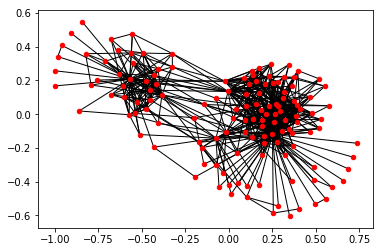

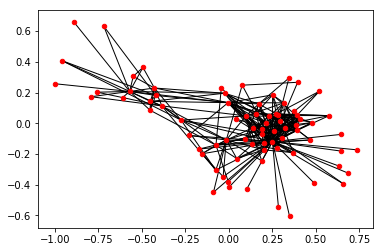

In [62]:
pos = nx.spring_layout(G2) # specify node positions
nx.draw_networkx_nodes(G2, pos, node_size=20) # draw nodes
nx.draw_networkx_edges(G2, pos) # draw edges
plt.show()

pos2 = nx.spring_layout(G2a, pos=pos) # specify node positions
pos2.update(pos)
nx.draw_networkx_nodes(G2a, pos2, node_size=20) # draw nodes
nx.draw_networkx_edges(G2a, pos2) # draw edges
plt.show()


This goes some of the way towards addressing our previous concerns. However;
1. Selecting links by section is an imperfect heuristic for choosing 'relevant' links.
2. Links are unweighted, so we have no sense of _how_ relevant pages are to each other.

### Clickstream Network <a name="clickstream"></a>

We can turn to the Wikipedia Clickstream dataset; a list of all the links between pages on Wikipedia, and how often they are clicked on.

This gives us links on a page that are selected for by relevance, as determined by how frequently they are used.

An added perk is that since this data is stored locally, the whole procedure is much quicker. We can even quickly generate 2-hop, 3-hop networks. I highly recommend using this method on the larger Wikipedias.

In [38]:
articles = ['Emmanuel Macron', 'Angela Merkel']
G3 = clickstream_network(articles, clickstream_dfs['en'], 'en') # generate clickstream network
G3a = clickstream_network(articles, clickstream_dfs['en'], 'en', cutoff=500, depth=2) # generate clickstream network, with a minimum edge weight of 500 and a search depth of2

print(nx.info(G3)) # print info
print(nx.info(G3a))

nx.write_graphml(G3, 'ClickstreamNetwork.graphml') # save graphs
nx.write_graphml(G3a, 'ClickstreamNetworkc1000d2.graphml')

getting links
getting redirects
0.00%
getting links
getting redirects
0.00%
Name: 
Type: Graph
Number of nodes: 697
Number of edges: 4552
Average degree:  13.0617
Name: 
Type: Graph
Number of nodes: 499
Number of edges: 1092
Average degree:   4.3768


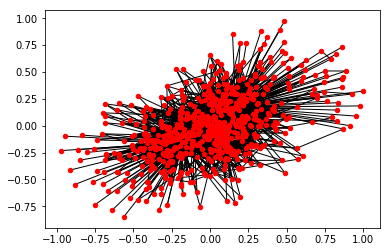

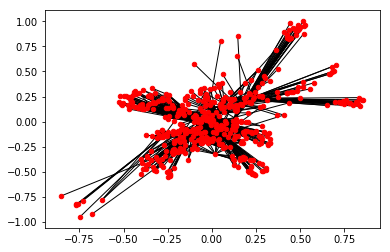

In [63]:
pos = nx.spring_layout(G3)
nx.draw_networkx_nodes(G3, pos, node_size=20)
nx.draw_networkx_edges(G3, pos)
plt.show()

pos2 = nx.spring_layout(G3a, pos=pos)
pos2.update(pos)
nx.draw_networkx_nodes(G3a, pos2, node_size=20)
nx.draw_networkx_edges(G3a, pos2)
plt.show()

## Studying a Network <a name="studying"></a>
Now that we are able to generate a network of articles, let's explore what we can do with them. We're going to:

1. Generate clickstream networks in multiple languages from the same core articles.
2. Get data on identity of editors and size of edits
3. Compute overlap of editors between languages (Finding multilingual editors)
4. Does article centrality correlate between languages? Are the important articles the same in different languages?
5. Compare network centrality against no. of editors & size of edits. Do the most visited articles receive more edits, editors and/or larger edits?


In [42]:
# 1. Generate Clickstream networks
orig_language = 'en'
articles = ['Emmanuel Macron', 'Angela Merkel']
languages = ['fr', 'de']

networks, translations = multi_lang_networks(articles, orig_language, languages, clickstream_network, **{'clickstream_dfs':clickstream_dfs, 'cutoff':0})

for k, i in networks.items(): # print network info
    print(k, nx.info(i))

en
getting links
getting redirects
0.00%
fr
getting links
getting redirects
0.00%
getting translations
de
getting links
getting redirects
0.00%
getting translations
en Name: 
Type: Graph
Number of nodes: 697
Number of edges: 4552
Average degree:  13.0617
fr Name: 
Type: Graph
Number of nodes: 395
Number of edges: 1290
Average degree:   6.5316
de Name: 
Type: Graph
Number of nodes: 341
Number of edges: 1230
Average degree:   7.2141


In [44]:
# 2. Get data on revisions, editors, and edit size for each network (in March 2019)
for k, v in networks.items():
    print(k)
    get_network_properties(v, {'prop':'revisions', 'rvprop':'user|size', 'rvlimit':'max', 'rvdir':'newer', 'rvstart':'20190301T000000'}, k, fix_redirects = True)
    nx.set_node_attributes(v, translations[k], name='translation')

nodes_df = {k: nodes_to_dataframe(v) for k, v in networks.items()}

en
0.00%
7.17%
14.35%
21.52%
28.69%
35.87%
43.04%
50.22%
57.39%
64.56%
71.74%
78.91%
86.08%
93.26%
fr
0.00%
12.66%
25.32%
37.97%
50.63%
63.29%
75.95%
88.61%
de
0.00%
14.66%
29.33%
43.99%
58.65%
73.31%
87.98%


In [45]:
# 3. Compile lists of editors in each language and print the overlap between language editions
editors = {k:set([x.get('user', None) for y in v['revisions'] for x in y ]) for k, v in nodes_df.items()}

for i in langlist:
    for j in langlist:
        if i != j:
            perc = 100*len(editors[i] & editors[j])/len(editors[i])
            print('%.1f%% of %s.wiki editors also edit %s.wiki' %(perc, i, j))


0.8% of en.wiki editors also edit fr.wiki
0.8% of en.wiki editors also edit de.wiki
2.4% of fr.wiki editors also edit en.wiki
0.4% of fr.wiki editors also edit de.wiki
2.6% of de.wiki editors also edit en.wiki
0.4% of de.wiki editors also edit fr.wiki


(0.08441020929539746, 0.2667305994484637)


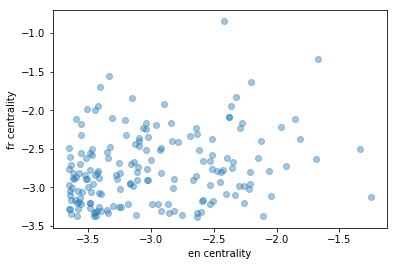

(0.09887003673360219, 0.23027904784379058)


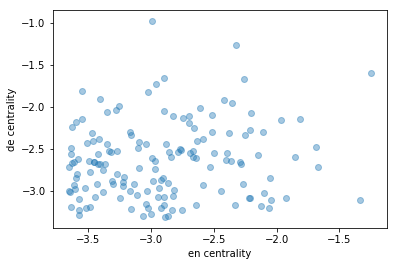

(0.17671578142690386, 0.0756082176336354)


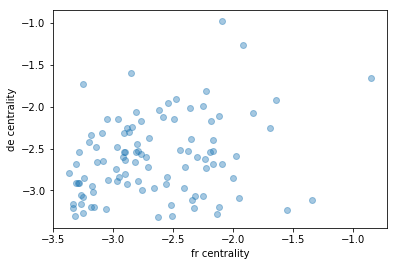

In [48]:
# 4. Generate scatter plots for centrality of articles present in 2 Wiki languages
from scipy.stats import pearsonr
import numpy as np

for k, v in networks.items():
    nodes_df[k]['Centrality'] = pd.Series(nx.pagerank(v))

for n, i in enumerate(langlist):
    for m, j in enumerate(langlist):
        if m>n:
            overlap = set(nodes_df[i]['translation'])&set(nodes_df[j]['translation'])-set([np.nan])
            x = nodes_df[i].set_index('translation')[nodes_df[i].set_index('translation').index.isin(overlap)]['Centrality']
            y = nodes_df[j].set_index('translation')[nodes_df[j].set_index('translation').index.isin(overlap)]['Centrality']
            plt.scatter(np.log10(x), np.log10(y), alpha=0.4)
            plt.ylabel(j+' centrality')
            plt.xlabel(i+' centrality')
            print(pearsonr(x,y))
            plt.show()

(0.3765707384131137, 1.465416722147408e-18)


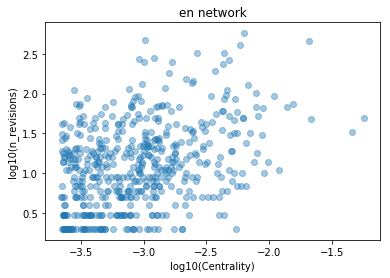

(0.37638422636030305, 1.5280916351601198e-18)


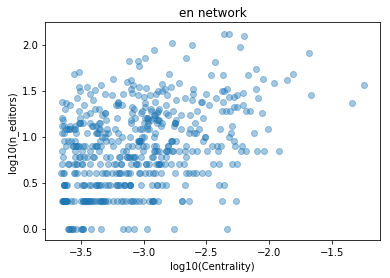

(0.13616336064685652, 0.0022097245894577245)


/Users/Patrick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


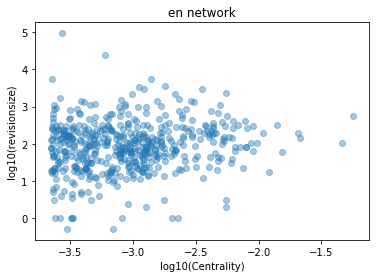

(0.5292155777254374, 5.172207597392088e-19)


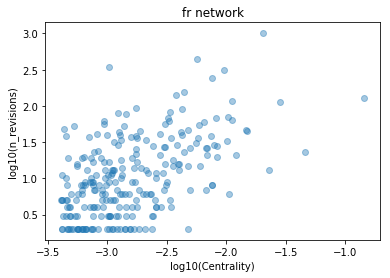

(0.5396394081736599, 7.688227288190027e-20)


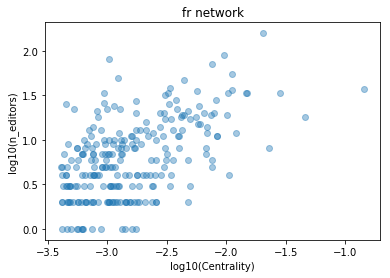

(0.22766782356679788, 0.00036680531015243574)


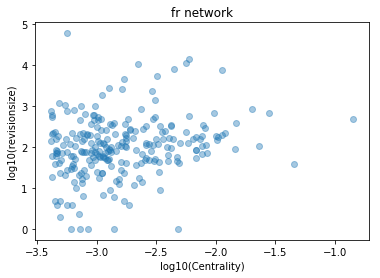

(0.3780660462252182, 8.146344826694688e-09)


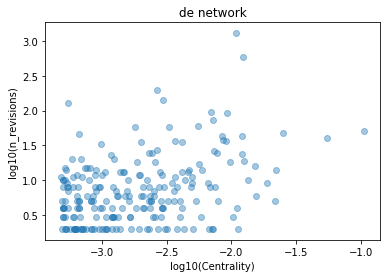

(0.40662364793560596, 4.3487193926411415e-10)


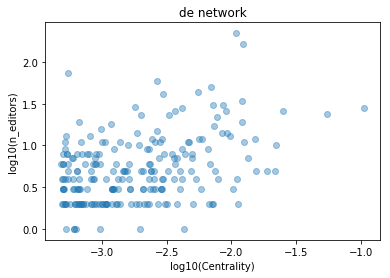

(0.09003965019248361, 0.18740056302589705)


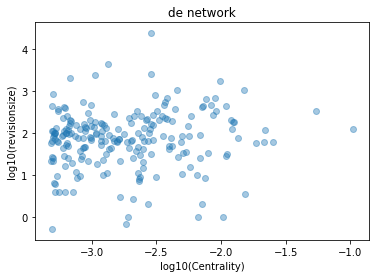

In [57]:
# 5. Generate scatter plots for centrality vs. number of editors, number of revisions & size of revisions.
def editsize(x):
    return abs(pd.Series([z['size'] for z in x]).shift(1)-pd.Series([z['size'] for z in x])).dropna()

for k, v in networks.items():
    
    nodes_df[k]['revisionsize'] = nodes_df[k]['revisions'].apply(lambda x: np.mean(editsize(x)))
    nodes_df[k]['n_revisions'] = nodes_df[k]['revisions'].apply(lambda x: len(x))
    nodes_df[k]['n_editors'] = nodes_df[k]['revisions'].apply(lambda x: len(set([z.get('user', None) for z in x])))

    data = nodes_df[k][['Centrality', 'revisionsize', 'n_revisions', 'n_editors']].dropna(subset=['revisionsize'])
    for n,i in enumerate(['n_revisions', 'n_editors', 'revisionsize']):
        plt.scatter(np.log10(data['Centrality']), np.log10(data[i]), alpha=0.4)
        plt.ylabel('log10(%s)' %i)
        plt.xlabel('log10(Centrality)')
        plt.title('%s network' %k)
        print(pearsonr(np.log10(data[data[i]>0]['Centrality']), np.log10(data[i][data[i]>0])))
        plt.show()    
    

## Appendix: Running a Query <a name="query"></a>

This skill has been skimmed over in this tutorial, and much of the heavy lifting has been handled in the pre-made functions. But if you want to run your own queries to download data on Wikipedia pages the following might be helpful.

Documentation available here: https://www.mediawiki.org/wiki/API:Properties

We can run a few queries to see the type of data being returned.

In [ ]:
articles = 'London|Berlin|Paris'

params = {'titles':articles, 'prop':'revisions'}
print(list(query(params, 'en')))

In [ ]:
params = {'titles':articles, 'prop':'links', 'pllimit':'max'}
for i in query(params, 'en'):
    print(i)